# 

In [1]:
import numpy as np
import pandas as pd
import os

In [2]:
test_dir = '/kaggle/input/raf-db-dataset/DATASET/test'
train_dir = '/kaggle/input/raf-db-dataset/DATASET/train'

In [3]:
!ls /kaggle/input/raf-db-dataset/DATASET/test/1/test_0002_aligned.jpg

/kaggle/input/raf-db-dataset/DATASET/test/1/test_0002_aligned.jpg


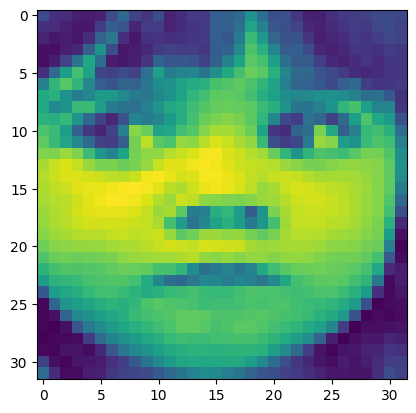

In [4]:
from PIL import Image,ImageOps

import matplotlib.pyplot as plt
import numpy as np

size = 32
    
required_size=(size, size)
image = ImageOps.grayscale(Image.open('/kaggle/input/raf-db-dataset/DATASET/test/1/test_0002_aligned.jpg')).resize(required_size)
img_arr = np.array(image)#.reshape(size*size)

imgplot = plt.imshow(img_arr)

In [5]:
def dataset_by_path(path):
    size = 64
    X = []
    y = []
    required_size=(size, size)
    i=0

    for class_name in os.listdir(path):
        path_to =path+'/'+class_name
        for img_path in os.listdir(path_to):
            y.append(int(class_name))
            
            image = ImageOps.grayscale(Image.open(path_to+'/'+img_path)).resize(required_size)
            img_arr = np.array(image).reshape(size*size)
            X.append(img_arr)
    return np.array(X),np.array(y)



In [6]:
test_f ,test_label =dataset_by_path(test_dir)
train_f ,train_label =dataset_by_path(train_dir)


In [7]:
print(train_f.shape)
print(train_label.shape)

(12271, 4096)
(12271,)


In [8]:
from pandas import DataFrame
import warnings
warnings.filterwarnings("ignore")

In [9]:
name_col= [str(i) for i in range(64*64)]
X_train = DataFrame()
X_train[name_col] = train_f
Y_train = DataFrame()
Y_train['label'] = train_label
X_test = DataFrame()
X_test[name_col] = test_f
Y_test = DataFrame()
Y_test['label'] = test_label

In [10]:
Y_train.value_counts()

label
4        4772
7        2524
5        1982
1        1290
3         717
6         705
2         281
Name: count, dtype: int64

In [11]:
import optuna

import catboost as cb
from sklearn.metrics import f1_score
from sklearn.decomposition import PCA

def objective(trial):
    x, xt, y, yt = train_f,test_f,train_label,test_label
    param = {
        "objective": trial.suggest_categorical("objective", ["MultiClass", "MultiClassOneVsAll"]),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.01, 0.1),
        "boosting_type": trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),
        "bootstrap_type": trial.suggest_categorical(
            "bootstrap_type", ["Bayesian", "Bernoulli"]
        ),
        "used_ram_limit": "25gb",
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'learning_rate': trial.suggest_categorical('learning_rate', [0.005, 0.02, 0.05, 0.08, 0.1]),
        'n_estimators': trial.suggest_int('n_estimators', 4, 200),
        'max_bin': trial.suggest_int('max_bin', 100, 400),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 1, 300),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 0.0001, 1.0, log=True),
        'random_seed': 42,
        'task_type': 'CPU',
        'eval_metric': 'Accuracy',
    }

    if param["bootstrap_type"] == "Bayesian":
        param["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0, 10)
    elif param["bootstrap_type"] == "Bernoulli":
        param["subsample"] = trial.suggest_float("subsample", 0.1, 1)
        
    pca_param ={
        "n_components": trial.suggest_float("n_components", 0.5, 0.9999),
        'power_iteration_normalizer': trial.suggest_categorical('power_iteration_normalizer',
            ['auto', 'QR', 'LU', 'none']
        ),
        'svd_solver':'full',

    }
    
    pca = PCA(**pca_param).fit(x,y)
    x = pca.transform(x)
    xt = pca.transform(xt)
    gbm = cb.CatBoostClassifier(**param)

    gbm.fit(x, y, eval_set=[(xt, yt)], verbose=0, early_stopping_rounds=10)
    preds = gbm.predict(xt)
    pred_labels = np.rint(preds)

    ac = gbm.get_best_score()['validation']['Accuracy']
    print(ac)
    return ac

In [ ]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=1000, timeout=600, n_jobs=-1)

print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2023-10-21 20:23:43,313] A new study created in memory with name: no-name-975e9d50-e4b2-4f96-8ed7-24f98a51e5cc
[I 2023-10-21 20:27:16,295] Trial 0 finished with value: 0.386245110821382 and parameters: {'objective': 'MultiClassOneVsAll', 'colsample_bylevel': 0.08565498024710487, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'max_depth': 3, 'learning_rate': 0.1, 'n_estimators': 176, 'max_bin': 313, 'min_data_in_leaf': 34, 'l2_leaf_reg': 0.002843705664839238, 'subsample': 0.9990533941623947, 'n_components': 0.6322272953065962, 'power_iteration_normalizer': 'QR'}. Best is trial 0 with value: 0.386245110821382.


0.386245110821382


[I 2023-10-21 20:27:16,969] Trial 3 finished with value: 0.386245110821382 and parameters: {'objective': 'MultiClass', 'colsample_bylevel': 0.0790349258786032, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'max_depth': 4, 'learning_rate': 0.005, 'n_estimators': 22, 'max_bin': 202, 'min_data_in_leaf': 40, 'l2_leaf_reg': 0.0015451675844879522, 'bagging_temperature': 0.9444351722150723, 'n_components': 0.521620525596555, 'power_iteration_normalizer': 'none'}. Best is trial 0 with value: 0.386245110821382.
[I 2023-10-21 20:27:17,101] Trial 2 finished with value: 0.386245110821382 and parameters: {'objective': 'MultiClass', 'colsample_bylevel': 0.06371876002718255, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'max_depth': 12, 'learning_rate': 0.05, 'n_estimators': 135, 'max_bin': 208, 'min_data_in_leaf': 13, 'l2_leaf_reg': 0.005534610151819907, 'subsample': 0.7465955123055596, 'n_components': 0.6204156910263755, 'power_iteration_normalizer': 'QR'}. Best is trial 0 

0.386245110821382
0.386245110821382


In [ ]:
x, xt, y, yt = train_f,test_f,train_label,test_label

gbm = cb.CatBoostClassifier(iterations=10,       eval_metric='Accuracy').fit(x, y, eval_set=[(xt, yt)], verbose=0, early_stopping_rounds=100)
print(gbm.get_best_score())
